In [1]:
import pandas as pd
from collections import defaultdict
import operator
from collections import Counter
import numpy as np
import sys
from scipy.stats import pearsonr 
import pylab 
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev

### Read in Data

In [2]:
# occupation annual average transformation rates: old skills retained rate, replaced skill rate, new skills growth rate
ot = {}
with open('/Users/ditong/Documents/large scale computing/final-project-di-Tong/mr_transrate.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")[1][1:-2].split("_")
        occ = line_lst[0]
        retained = float(line_lst[1])
        replaced =float(line_lst[2])
        growth = float(line_lst[3])
        ot[occ] = (retained, replaced, growth)

In [3]:
# Occupation name, demand, pay, education level
yjn = defaultdict(lambda:defaultdict(lambda:0))
jyn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
jyp = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/occ_year_freq_edu_pay.txt','r') as f:
    for line in f:
        line_lst = line.split('\t')
        job = line_lst[0]
        year = int(line_lst[1])
        num = line_lst[2]
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            yjn[year][job] = int(num) 
            jyn[job][year] = int(num)
            if edu != 'nan' and edu != 'nan\n': 
                med_edu = edu.split('_')[1]
                if med_edu != 'nan' and float(med_edu) > 0:
                    jye[job][year] = float(med_edu)
            if pay != 'nan' and pay != 'nan\n':
                med_pay = pay.split('_')[1]
                if med_pay != 'nan' and float(med_pay) > 0:
                    jyp[job][year] = float(med_pay)

In [4]:
# get annual average number for demand, pay, education for each occupation
on = defaultdict(lambda:0)
oe = defaultdict(lambda:0)
op = defaultdict(lambda:0)
for job in jyn:
    on[job] = int(mean(jyn[job].values()))
for job in jye:
    oe[job] = mean(jye[job].values())
for job in jyp:
    op[job] = mean(jyp[job].values())

In [5]:
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Documents/skillProject/description/data/SOC/occ_skill_tfidf.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0]
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf

# filter the defining skills
jys = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for year in yjas:
    for job in yjas[year]:
        threshold = mean(yjas[year][job].values())
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year][skill] = yjas[year][job][skill]
        if len(jys[job][year]) < 5:
            del jys[job][year]

# calculate the average annual skill number change of occupations from each year
osn = {}
for job in jys:
    osn[job] = mean([len(m) for m in jys[job].values()])

In [6]:
df_2018=pd.read_excel('/Users/ditong/Documents/skillProject/description/data/SOC/BLS/national_M2018_dl.xlsx')

In [7]:
ocg={}
cg = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['OCC_GROUP'], df_2018['OCC_CODE']):
    if j=='major':
        cg[k[:2]] = i
    elif j == 'detailed':
        ocg[i] = cg[k[:2]]

go = defaultdict(lambda:set())
for occ in ocg:
    go[ocg[occ]].add(occ)
    
gon = defaultdict(lambda:defaultdict(lambda:0))
for g in go:
    for o in go[g]:
        if o in on:
            gon[g][o] = on[o]

In [8]:
cao = defaultdict(lambda:[])
with open('/Users/ditong/Documents/skillProject/description/data/SOC/bg_occ_cararea.txt', 'r') as f:
    for line in f:
        cao[line.split('\t')[1][:-1]].append(line.split('\t')[0])

caon = defaultdict(lambda:defaultdict(lambda:0))
for g in cao:
    for o in cao[g]:
        if o in on:
            caon[g][o] = on[o]

In [9]:
CR={}#computerization risk by Frey #https://www.oxfordmartin.ox.ac.uk/publications/the-future-of-employment/
n=0
with open('/Users/ditong/Documents/skillProject/description/data/rank_probability_label_soc_occupation.txt','r', encoding="utf-8") as f:
    for line in f:
        rank,pro,label,jobcode,jobname=line.strip().split('\t')
        if pro:
            CR[jobname]=float(pro)

### Simple Validation and Description before Diving in

In [11]:
t, p, g = zip(*ot.values())

In [12]:
mean(t), mean(p), mean(g)

(0.668740232890106, 0.331259767109894, 0.43822673919499283)

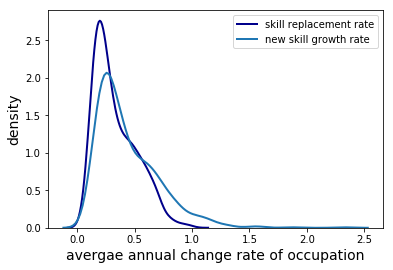

In [13]:
sns.distplot(list(p), hist=False, kde=True, bins=50, color='darkblue',
            kde_kws={'linewidth': 2}, label='skill replacement rate')   
sns.distplot(list(g), hist=False, kde=True, bins=50, 
            kde_kws={'linewidth': 2}, label='new skill growth rate')   
plt.xlabel('avergae annual change rate of occupation', fontsize =14)
plt.ylabel('density', fontsize =14)
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillrepl_gro.png", bbox_inches='tight')

In [129]:
sorted([(v[1], k) for k,v in ot.items()])[:10]

[(0.06747622475999453, 'Computer Occupations, All Other'),
 (0.07156969041583516, 'Software Developers, Applications'),
 (0.07568756882706648, 'Financial Managers'),
 (0.07601091341284678, 'Network and Computer Systems Administrators'),
 (0.0799698223285498,
  'Secretaries and Administrative Assistants, Except Legal, Medical, and Executive'),
 (0.08046914582941847, 'Marketing Managers'),
 (0.08069757161777485, 'Financial Analysts'),
 (0.0816556474822977, 'Managers, All Other'),
 (0.08392774993868797, 'Information Security Analysts'),
 (0.0853155213943338, 'Database Administrators')]

In [130]:
sorted([(v[1], k) for k,v in ot.items()], reverse=True)[:10]

[(0.9871794871794872, 'Derrick Operators, Oil and Gas'),
 (0.9598370927318295, 'Cooks, Private Household'),
 (0.9392636670761672, 'Farm Labor Contractors'),
 (0.9178383838383839, 'Roof Bolters, Mining'),
 (0.912967032967033,
  'First-Line Supervisors of Weapons Specialists/Crew Members'),
 (0.8664941902687001, 'Model Makers, Wood'),
 (0.8563885934853677, 'Tapers'),
 (0.8313983152295493, 'Gaming Managers'),
 (0.8242641227780065, 'Choreographers'),
 (0.8215155945419104, 'Mathematical Science Occupations, All Other')]

In [131]:
sorted([(v[2], k) for k,v in ot.items()])[:10]

[(0.09182686449639375, 'Software Developers, Applications'),
 (0.09620191992944158, 'Computer Occupations, All Other'),
 (0.0998224203621964, 'Web Developers'),
 (0.10145557472397015, 'Marketing Managers'),
 (0.10716794927169866, 'Financial Managers'),
 (0.10763347816883191, 'Registered Nurses'),
 (0.10880807092662306, 'Network and Computer Systems Administrators'),
 (0.10914944873169882, 'Managers, All Other'),
 (0.11162080359449174, 'Financial Analysts'),
 (0.11198028595770766, 'Bookkeeping, Accounting, and Auditing Clerks')]

In [132]:
sorted([(v[2], k) for k,v in ot.items()], reverse=True)[:10]

[(2.3177333009518297, 'Command and Control Center Specialists'),
 (1.8624797092621004, 'Radar and Sonar Technicians'),
 (1.5808488342591605, 'Farm Labor Contractors'),
 (1.568070205937853, 'Shampooers'),
 (1.5135338345864662, 'Cooks, Private Household'),
 (1.3322743289848553, 'Mathematical Science Occupations, All Other'),
 (1.3211347853942135, 'Gaming Managers'),
 (1.3034523028918872, 'Postmasters and Mail Superintendents'),
 (1.258434065934066, 'Media and Communication Equipment Workers, All Other'),
 (1.235856161675834, 'Mechanical Door Repairers')]

correlation, pvalue: (-1.0, 0.0)


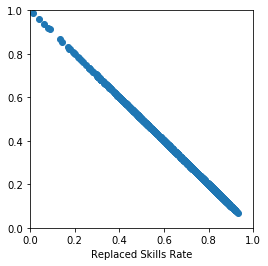

In [42]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(t,p)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Old Skills Retaining Rate")
plt.xlabel("Replaced Skills Rate")
print("correlation, pvalue:", pearsonr(t,p))

correlation, pvalue: (0.9181367408079879, 0.0)


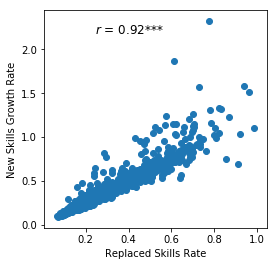

In [36]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(p,g)
plt.xlabel("Replaced Skills Rate")
plt.ylabel("New Skills Growth Rate")
plt.figtext(0.3, 0.8, r'$r$' + ' = ' + '0.92***', fontsize=12)  
print("correlation, pvalue:", pearsonr(p,g))

plt.savefig("/Users/ditong/Documents/skillProject/description/vis/repl_gro.png", bbox_inches='tight')

### What Kind of Job tends to transform? 

### Education vs Transformation  

In [14]:
ert = defaultdict(lambda:[])
erp = defaultdict(lambda:[])
eg = defaultdict(lambda:[])
for job in oe:
    jp = np.round(oe[job])
    if job in ot:
        ert[jp].append(ot[job][0]) 
        erp[jp].append(ot[job][1]) 
        eg[jp].append(ot[job][2]) 

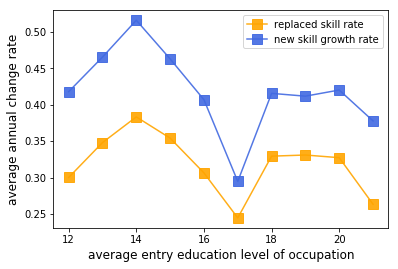

In [15]:
# x,y=np.array(sorted([(k,np.mean(v)) for k,v in ert.items()])).T
# corr1=pearsonr(np.array(x), np.array(y))
# plt.plot(x,y, marker='s',color='green',markersize=10,alpha=.9, label="retaining skill rate")

x,y=np.array(sorted([(k,np.mean(v)) for k,v in erp.items()])).T
corr2=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='orange',markersize=10,alpha=.9, label="replaced skill rate")

x,y=np.array(sorted([(k,np.mean(v)) for k,v in eg.items()])).T
corr3=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='royalblue',markersize=10,alpha=.9, label="new skill growth rate")

plt.ylabel('average annual change rate', fontsize=12)
plt.xlabel('average entry education level of occupation', fontsize=12)    
plt.legend()
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillreplgro_edu.png", bbox_inches='tight')

In [17]:
corr2, corr3

((-0.3840538830513427, 0.27321613907206094),
 (-0.4554482602831428, 0.1859200613172701))

In [233]:
ho = [k for k,v in oe.items() if v >= 16]
mo = [k for k,v in oe.items() if 14 <= v < 16]
lo = [k for k,v in oe.items() if v < 14]
len(ho),len(mo), len(lo)

(235, 257, 339)

In [38]:
ho = [k for k,v in oe.items() if v >= 16]
mo = [k for k,v in oe.items() if 14 <= v < 16]
lo = [k for k,v in oe.items() if v < 14]
len(ho),len(mo), len(lo)

(235, 257, 339)

### high edu occupations: top and bottom changing forces

In [136]:
points = np.percentile([v[1] for k, v in ot.items() if k in ho], (25, 50, 75), interpolation='midpoint')
print(points)
t25 = points[2]
med = points[1]
b25 = points[0]
otop = [k for k, v in ot.items() if k in ho and v[1] > med]
ob = [k for k, v in ot.items() if k in ho and v[1] <= med]
otop1 = [k for k, v in ot.items() if k in ho and v[1] >= t25]
ob1 = [k for k, v in ot.items() if k in ho and v[1] <= b25]

[0.1623033  0.22767283 0.34574371]


In [137]:
gcnt = defaultdict(lambda:0)
for occ in otop1:
    if occ in ocg:
        gcnt[ocg[occ]] += 1
gcnt = sorted(gcnt.items(), key=operator.itemgetter(1), reverse=True)
gcnt

[('Education, Training, and Library Occupations', 23),
 ('Life, Physical, and Social Science Occupations', 11),
 ('Healthcare Practitioners and Technical Occupations', 5),
 ('Architecture and Engineering Occupations', 4),
 ('Arts, Design, Entertainment, Sports, and Media Occupations', 2),
 ('Legal Occupations', 2),
 ('Construction and Extraction Occupations', 2),
 ('Transportation and Material Moving Occupations', 1),
 ('Building and Grounds Cleaning and Maintenance Occupations', 1),
 ('Business and Financial Operations Occupations', 1),
 ('Computer and Mathematical Occupations', 1),
 ('Sales and Related Occupations', 1),
 ('Community and Social Service Occupations', 1),
 ('Farming, Fishing, and Forestry Occupations', 1)]

In [138]:
gcnt = defaultdict(lambda:0)
for occ in ob1:
    if occ in ocg:
        gcnt[ocg[occ]] += 1
gcnt = sorted(gcnt.items(), key=operator.itemgetter(1), reverse=True)
gcnt

[('Management Occupations', 14),
 ('Computer and Mathematical Occupations', 11),
 ('Architecture and Engineering Occupations', 7),
 ('Business and Financial Operations Occupations', 7),
 ('Healthcare Practitioners and Technical Occupations', 6),
 ('Education, Training, and Library Occupations', 5),
 ('Arts, Design, Entertainment, Sports, and Media Occupations', 4),
 ('Life, Physical, and Social Science Occupations', 3),
 ('Legal Occupations', 1),
 ('Community and Social Service Occupations', 1)]

In [234]:
sorted([(v[1],k) for k, v in ot.items() if k in ho], reverse=True)[:10] 

[(0.9871794871794872, 'Derrick Operators, Oil and Gas'),
 (0.912967032967033,
  'First-Line Supervisors of Weapons Specialists/Crew Members'),
 (0.8563885934853677, 'Tapers'),
 (0.7973749119097957, 'Library Science Teachers, Postsecondary'),
 (0.7732282319175646, 'Command and Control Center Specialists'),
 (0.7490239284356932, 'Broadcast News Analysts'),
 (0.7055115891053391, 'Motorboat Operators'),
 (0.6950951095687938, 'Social Sciences Teachers, Postsecondary, All Other'),
 (0.687736257777305, 'Agricultural Sciences Teachers, Postsecondary'),
 (0.6805975636843706,
  'Area, Ethnic, and Cultural Studies Teachers, Postsecondary')]

In [235]:
sorted([(v[1],k) for k, v in ot.items() if k in ho])[:10] 

[(0.06747622475999453, 'Computer Occupations, All Other'),
 (0.07156969041583516, 'Software Developers, Applications'),
 (0.07568756882706648, 'Financial Managers'),
 (0.08046914582941847, 'Marketing Managers'),
 (0.08069757161777485, 'Financial Analysts'),
 (0.0816556474822977, 'Managers, All Other'),
 (0.08392774993868797, 'Information Security Analysts'),
 (0.0853155213943338, 'Database Administrators'),
 (0.08749298280718737, 'Accountants and Auditors'),
 (0.08754783795628852, 'Web Developers')]

In [156]:
sorted([(v[2],k) for k, v in ot.items() if k in ho], reverse=True)[:10] 

[(2.3177333009518297, 'Command and Control Center Specialists'),
 (1.1178177685700152, 'Prosthodontists'),
 (1.1106570165945167, 'Motorboat Operators'),
 (1.1055167055167054, 'Derrick Operators, Oil and Gas'),
 (1.0268867616735833, 'Library Science Teachers, Postsecondary'),
 (1.0229601782233362, 'Geography Teachers, Postsecondary'),
 (0.9933333333333334, 'Air Crew Officers'),
 (0.9825605102178693, 'Grounds Maintenance Workers, All Other'),
 (0.9790177974001504, 'Broadcast News Analysts'),
 (0.9530396578921423, 'Podiatrists')]

In [157]:
sorted([(v[2],k) for k, v in ot.items() if k in ho])[:10] 

[(0.09182686449639375, 'Software Developers, Applications'),
 (0.09620191992944158, 'Computer Occupations, All Other'),
 (0.0998224203621964, 'Web Developers'),
 (0.10145557472397015, 'Marketing Managers'),
 (0.10716794927169866, 'Financial Managers'),
 (0.10914944873169882, 'Managers, All Other'),
 (0.11162080359449174, 'Financial Analysts'),
 (0.11198775496248611, 'Market Research Analysts and Marketing Specialists'),
 (0.11467631569352224, 'Information Security Analysts'),
 (0.11504268083116521, 'Accountants and Auditors')]

### mid edu occupations: top and bottom changing forces

In [39]:
points = np.percentile([v[1] for k, v in ot.items() if k in mo], (25, 50, 75), interpolation='midpoint')
print(points)
t25 = points[2]
med = points[1]
b25 = points[0]
otop = [k for k, v in ot.items() if k in mo and v[1] > med]
ob = [k for k, v in ot.items() if k in mo and v[1] <= med]
otop1 = [k for k, v in ot.items() if k in mo and v[1] >= t25]
ob1 = [k for k, v in ot.items() if k in mo and v[1] <= b25]

[0.18117232 0.31136158 0.52429649]


In [151]:
gcnt = defaultdict(lambda:0)
for occ in otop1:
    if occ in ocg:
        gcnt[ocg[occ]] += 1
gcnt = sorted(gcnt.items(), key=operator.itemgetter(1), reverse=True)
gcnt

[('Production Occupations', 12),
 ('Arts, Design, Entertainment, Sports, and Media Occupations', 8),
 ('Installation, Maintenance, and Repair Occupations', 7),
 ('Construction and Extraction Occupations', 6),
 ('Transportation and Material Moving Occupations', 5),
 ('Farming, Fishing, and Forestry Occupations', 3),
 ('Office and Administrative Support Occupations', 3),
 ('Personal Care and Service Occupations', 2),
 ('Management Occupations', 2),
 ('Legal Occupations', 2),
 ('Sales and Related Occupations', 1),
 ('Life, Physical, and Social Science Occupations', 1),
 ('Business and Financial Operations Occupations', 1),
 ('Protective Service Occupations', 1),
 ('Building and Grounds Cleaning and Maintenance Occupations', 1)]

In [160]:
gcnt = defaultdict(lambda:0)
for occ in ob1:
    if occ in ocg:
        gcnt[ocg[occ]] += 1
gcnt = sorted(gcnt.items(), key=operator.itemgetter(1), reverse=True)
gcnt

[('Office and Administrative Support Occupations', 12),
 ('Business and Financial Operations Occupations', 10),
 ('Healthcare Practitioners and Technical Occupations', 7),
 ('Architecture and Engineering Occupations', 4),
 ('Arts, Design, Entertainment, Sports, and Media Occupations', 4),
 ('Management Occupations', 4),
 ('Sales and Related Occupations', 4),
 ('Computer and Mathematical Occupations', 3),
 ('Healthcare Support Occupations', 2),
 ('Production Occupations', 2),
 ('Education, Training, and Library Occupations', 2),
 ('Legal Occupations', 1),
 ('Installation, Maintenance, and Repair Occupations', 1),
 ('Life, Physical, and Social Science Occupations', 1),
 ('Community and Social Service Occupations', 1),
 ('Protective Service Occupations', 1),
 ('Food Preparation and Serving Related Occupations', 1)]

In [161]:
sorted([(v[1],k) for k, v in ot.items() if k in mo], reverse=True)[:10] 

[(0.9392636670761672, 'Farm Labor Contractors'),
 (0.9178383838383839, 'Roof Bolters, Mining'),
 (0.8664941902687001, 'Model Makers, Wood'),
 (0.8313983152295493, 'Gaming Managers'),
 (0.8242641227780065, 'Choreographers'),
 (0.8215155945419104, 'Mathematical Science Occupations, All Other'),
 (0.8077963915835626, 'Mine Shuttle Car Operators'),
 (0.8037657369512208, 'Timing Device Assemblers and Adjusters'),
 (0.78199478742125, 'Postmasters and Mail Superintendents'),
 (0.73572051673081, 'Musical Instrument Repairers and Tuners')]

In [240]:
sorted([(v[1],k) for k, v in ot.items() if k in mo])[:20] 

[(0.07601091341284678, 'Network and Computer Systems Administrators'),
 (0.0799698223285498,
  'Secretaries and Administrative Assistants, Except Legal, Medical, and Executive'),
 (0.08949312465137006, 'Bookkeeping, Accounting, and Auditing Clerks'),
 (0.09249557241188784, 'Registered Nurses'),
 (0.09636457292707293, 'Armored Assault Vehicle Crew Members'),
 (0.09675599718901892, 'Computer User Support Specialists'),
 (0.10214765235108278, 'Human Resources Specialists'),
 (0.10645074798849108, 'Medical Records and Health Information Technicians'),
 (0.10678766793101954,
  'Purchasing Agents, Except Wholesale, Retail, and Farm Products'),
 (0.10827439651807094, 'Legal Secretaries'),
 (0.10949132586990495, 'Graphic Designers'),
 (0.11304353464976946, 'Logisticians'),
 (0.11568406971778226, 'Loan Officers'),
 (0.11682541575894254, 'Respiratory Therapists'),
 (0.11709647369722728,
  'Securities, Commodities, and Financial Services Sales Agents'),
 (0.117739791827463,
  'Sales Representativ

In [211]:
sorted([(v[2],k) for k, v in ot.items() if k in mo], reverse=True)[:10] 

[(1.8624797092621004, 'Radar and Sonar Technicians'),
 (1.5808488342591605, 'Farm Labor Contractors'),
 (1.3322743289848553, 'Mathematical Science Occupations, All Other'),
 (1.3211347853942135, 'Gaming Managers'),
 (1.3034523028918872, 'Postmasters and Mail Superintendents'),
 (1.258434065934066, 'Media and Communication Equipment Workers, All Other'),
 (1.2228803558460422, 'Model Makers, Wood'),
 (1.1479547997878972, 'Hunters and Trappers'),
 (1.1478418557491226, 'Jewelers and Precious Stone and Metal Workers'),
 (1.1428571428571428, 'Pile-Driver Operators')]

In [212]:
sorted([(v[2],k) for k, v in ot.items() if k in mo])[:10] 

[(0.10763347816883191, 'Registered Nurses'),
 (0.10880807092662306, 'Network and Computer Systems Administrators'),
 (0.11198028595770766, 'Bookkeeping, Accounting, and Auditing Clerks'),
 (0.1186047090605245, 'Computer User Support Specialists'),
 (0.12043099666163329, 'Graphic Designers'),
 (0.12821101994620643, 'Human Resources Specialists'),
 (0.13568797545181877,
  'Purchasing Agents, Except Wholesale, Retail, and Farm Products'),
 (0.13574559481988954,
  'Sales Representatives, Wholesale and Manufacturing, Except Technical and Scientific Products'),
 (0.13937698488023242,
  'Secretaries and Administrative Assistants, Except Legal, Medical, and Executive'),
 (0.14101676215000544, 'Loan Officers')]

### low edu occupations: top and bottom changing forces

In [168]:
points = np.percentile([v[1] for k, v in ot.items() if k in lo], (25, 50, 75), interpolation='midpoint')
print(points)
t25 = points[2]
med = points[1]
b25 = points[0]
otop = [k for k, v in ot.items() if k in lo and v[1] > med]
ob = [k for k, v in ot.items() if k in lo and v[1] <= med]
otop1 = [k for k, v in ot.items() if k in lo and v[1] >= t25]
ob1 = [k for k, v in ot.items() if k in lo and v[1] <= b25]

[0.21219906 0.30612371 0.45857189]


In [169]:
gcnt = defaultdict(lambda:0)
for occ in otop1:
    if occ in ocg:
        gcnt[ocg[occ]] += 1
gcnt = sorted(gcnt.items(), key=operator.itemgetter(1), reverse=True)
gcnt

[('Production Occupations', 35),
 ('Construction and Extraction Occupations', 17),
 ('Transportation and Material Moving Occupations', 9),
 ('Personal Care and Service Occupations', 7),
 ('Installation, Maintenance, and Repair Occupations', 6),
 ('Farming, Fishing, and Forestry Occupations', 3),
 ('Food Preparation and Serving Related Occupations', 2),
 ('Office and Administrative Support Occupations', 1),
 ('Education, Training, and Library Occupations', 1),
 ('Sales and Related Occupations', 1),
 ('Arts, Design, Entertainment, Sports, and Media Occupations', 1),
 ('Protective Service Occupations', 1)]

In [170]:
gcnt = defaultdict(lambda:0)
for occ in ob1:
    if occ in ocg:
        gcnt[ocg[occ]] += 1
gcnt = sorted(gcnt.items(), key=operator.itemgetter(1), reverse=True)
gcnt

[('Construction and Extraction Occupations', 13),
 ('Production Occupations', 10),
 ('Installation, Maintenance, and Repair Occupations', 9),
 ('Office and Administrative Support Occupations', 9),
 ('Healthcare Practitioners and Technical Occupations', 9),
 ('Healthcare Support Occupations', 8),
 ('Food Preparation and Serving Related Occupations', 7),
 ('Building and Grounds Cleaning and Maintenance Occupations', 4),
 ('Transportation and Material Moving Occupations', 3),
 ('Sales and Related Occupations', 3),
 ('Personal Care and Service Occupations', 2),
 ('Architecture and Engineering Occupations', 2),
 ('Management Occupations', 1),
 ('Arts, Design, Entertainment, Sports, and Media Occupations', 1),
 ('Protective Service Occupations', 1),
 ('Education, Training, and Library Occupations', 1)]

In [171]:
sorted([(v[1],k) for k, v in ot.items() if k in lo], reverse=True)[:10] 

[(0.9598370927318295, 'Cooks, Private Household'),
 (0.7834194464130239, 'Gaming Change Persons and Booth Cashiers'),
 (0.7619047619047619, 'Fabric Menders, Except Garment'),
 (0.7344168642660022, 'Motorcycle Mechanics'),
 (0.7309386895783955, 'Shampooers'),
 (0.7160797368522066, 'Manufactured Building and Mobile Home Installers'),
 (0.7, 'First-Line Supervisors of All Other Tactical Operations Specialists'),
 (0.6995410839160839,
  'Helpers--Painters, Paperhangers, Plasterers, and Stucco Masons'),
 (0.6964120134284578, 'Rail Yard Engineers, Dinkey Operators, and Hostlers'),
 (0.6854042428003837, 'Pourers and Casters, Metal')]

In [172]:
sorted([(v[1],k) for k, v in ot.items() if k in lo])[:10] 

[(0.10582131483985671, 'Dental Assistants'),
 (0.10826562618276434, 'Medical Assistants'),
 (0.11022593883669646, 'Customer Service Representatives'),
 (0.11166354058955484, 'First-Line Supervisors of Retail Sales Workers'),
 (0.11183488102341377, 'Tellers'),
 (0.11638697395779038, 'Food Service Managers'),
 (0.11812003240786685, 'Nursing Assistants'),
 (0.11873109484380857, 'Medical Secretaries'),
 (0.12084667184317094, 'Electricians'),
 (0.12244079049952583, 'Licensed Practical and Licensed Vocational Nurses')]

In [173]:
sorted([(v[2],k) for k, v in ot.items() if k in lo], reverse=True)[:10] 

[(1.568070205937853, 'Shampooers'),
 (1.5135338345864662, 'Cooks, Private Household'),
 (1.235856161675834, 'Mechanical Door Repairers'),
 (1.2043220062857818, 'Cooling and Freezing Equipment Operators and Tenders'),
 (1.1606115351162947, 'Gaming Change Persons and Booth Cashiers'),
 (1.1458628736854544, 'Paperhangers'),
 (1.1288801476301478,
  'Helpers--Painters, Paperhangers, Plasterers, and Stucco Masons'),
 (1.0785782298351034, 'Floor Layers, Except Carpet, Wood, and Hard Tiles'),
 (1.0785714285714285,
  'First-Line Supervisors of All Other Tactical Operations Specialists'),
 (0.99786730761046, 'Pourers and Casters, Metal')]

In [174]:
sorted([(v[2],k) for k, v in ot.items() if k in lo])[:10] 

[(0.14155218602065386, 'Customer Service Representatives'),
 (0.14174280680383855, 'Dental Assistants'),
 (0.14776932627237818, 'Maintenance and Repair Workers, General'),
 (0.1487194339541659, 'Licensed Practical and Licensed Vocational Nurses'),
 (0.1521024894951487, 'Medical Assistants'),
 (0.15703142852893304, 'Nursing Assistants'),
 (0.16336908760991514, 'Electricians'),
 (0.16585211971946762, 'Industrial Engineering Technicians'),
 (0.16773554998451548, 'First-Line Supervisors of Retail Sales Workers'),
 (0.17207180729072485, 'Medical Secretaries')]

In [57]:
ert = defaultdict(lambda:[])
erp = defaultdict(lambda:[])
eg = defaultdict(lambda:[])
for job in oe:
    if job in ot:
        ert[job] = (oe[job], ot[job][0])
        erp[job] = (oe[job], ot[job][1])
        eg[job]= (oe[job], ot[job][2])

(0.0903256436727347, 0.009351355161387173)

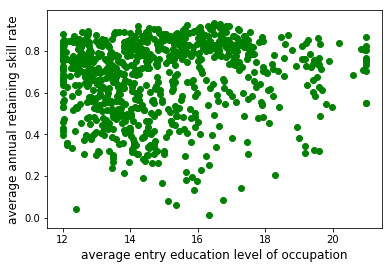

In [63]:
x,y=zip(*ert.values())
corr1=pearsonr(np.array(x), np.array(y))
plt.scatter(x,y, color='green')
plt.ylabel('average annual retaining skill rate', fontsize=12)
plt.xlabel('average entry education level of occupation', fontsize=12)    
corr1

(-0.09032564367273471, 0.009351355161387173)

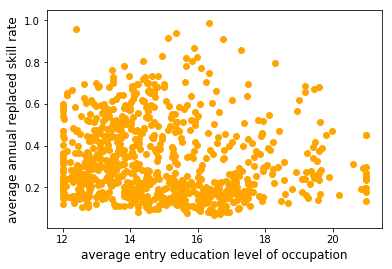

In [64]:
x,y=zip(*erp.values())
corr2=pearsonr(np.array(x), np.array(y))
plt.scatter(x,y, color='orange')
plt.ylabel('average annual replaced skill rate', fontsize=12)
plt.xlabel('average entry education level of occupation', fontsize=12)    
corr2

(-0.11936614670210076, 0.0005821482893722663)

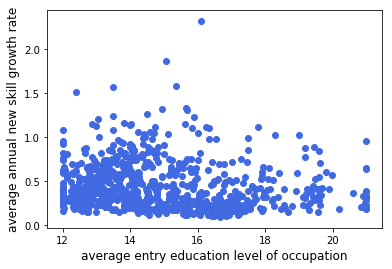

In [67]:
x,y=zip(*eg.values())
corr3=pearsonr(np.array(x), np.array(y))
plt.scatter(x,y, color='royalblue')
plt.ylabel('average annual new skill growth rate', fontsize=12)
plt.xlabel('average entry education level of occupation', fontsize=12)    
corr3

### Pay vs Transformation

In [18]:
prt = defaultdict(lambda:[])
prp = defaultdict(lambda:[])
pg = defaultdict(lambda:[])
for job in op:
    jp = np.round(op[job])
    if job in ot:
        prt[jp].append(ot[job][0]) 
        prp[jp].append(ot[job][1]) 
        pg[jp].append(ot[job][2]) 

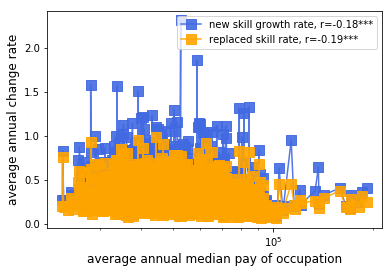

In [27]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in pg.items()])).T
corr1=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='royalblue',markersize=10,alpha=.9, label="new skill growth rate, r=-0.18***")

x,y=np.array(sorted([(k,np.mean(v)) for k,v in prp.items()])).T
corr2=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='orange',markersize=10,alpha=.9, label="replaced skill rate, r=-0.19***")

plt.xscale("log")
plt.ylabel('average annual change rate', fontsize=12)
plt.xlabel('average annual median pay of occupation', fontsize=12)    
plt.legend()
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillreplgro_pay.png", bbox_inches='tight')

In [20]:
corr1, corr2

((-0.18392741428695109, 1.0356465988671915e-07),
 (-0.19230044532186727, 2.5905296993468633e-08))

### Skill Number (Job Complexity) vs Transformation

In [21]:
snrt = defaultdict(lambda:[])
snrp = defaultdict(lambda:[])
sng = defaultdict(lambda:[])
for job in osn:
    jp = np.round(osn[job])
    if job in ot:
        snrt[jp].append(ot[job][0]) 
        snrp[jp].append(ot[job][1]) 
        sng[jp].append(ot[job][2]) 

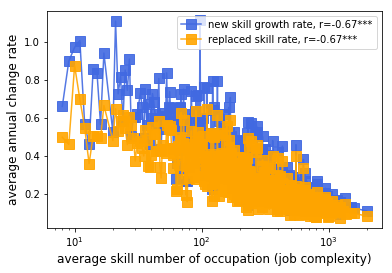

In [28]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in sng.items()])).T
corr1=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='royalblue',markersize=10,alpha=.9, label="new skill growth rate, r=-0.67***")

x,y=np.array(sorted([(k,np.mean(v)) for k,v in snrp.items()])).T
corr2=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='orange',markersize=10,alpha=.9, label="replaced skill rate, r=-0.67***")

plt.xscale("log")
plt.ylabel('average annual change rate', fontsize=12)
plt.xlabel('average skill number of occupation (job complexity)', fontsize=12)    
plt.legend()
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillreplgro_sn.png", bbox_inches='tight')

In [23]:
corr1, corr2

((-0.6685992702240262, 3.2119609263608425e-55),
 (-0.6722098573019549, 5.17554154897073e-56))

### Computerization Risk vs Transformation

In [24]:
crrt = defaultdict(lambda:[])
crrp = defaultdict(lambda:[])
crg = defaultdict(lambda:[])
for job in CR:
    jp = np.round(CR[job], 1)
    if job in ot:
        crrt[jp].append(ot[job][0]) 
        crrp[jp].append(ot[job][1]) 
        crg[jp].append(ot[job][2]) 

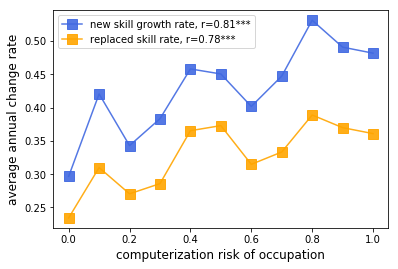

In [29]:
x,y=np.array(sorted([(k,np.mean(v)) for k,v in crg.items()])).T
corr1=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='royalblue',markersize=10,alpha=.9, label="new skill growth rate, r=0.81***")

x,y=np.array(sorted([(k,np.mean(v)) for k,v in crrp.items()])).T
corr2=pearsonr(np.array(x), np.array(y))
plt.plot(x,y, marker='s',color='orange',markersize=10,alpha=.9, label="replaced skill rate, r=0.78***")

plt.ylabel('average annual change rate', fontsize=12)
plt.xlabel('computerization risk of occupation', fontsize=12)    
plt.legend()
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillreplgro_cr.png", bbox_inches='tight')

In [26]:
corr1, corr2

((0.8148887122775843, 0.00224699707174866),
 (0.7776174822210652, 0.004842172908048899))

### Career Area / Major Occupational Group

In [31]:
def get_ind_score_df(dic_ind_job_num, dic_2, name, year=False):

    ind_score={}
    for ind in dic_ind_job_num:
        jp=defaultdict(lambda:0)
        for job in dic_ind_job_num[ind]:
            if job in dic_2:
                jp[job]+=dic_ind_job_num[ind][job]
        s=sum(jp.values())
        jp=dict((k,v/s) for k,v in jp.items())
        score=sum([jp[i]*dic_2[i] for i in jp])
        ind_score[ind]=score

    sorted_ind_score = sorted(ind_score.items(), key=operator.itemgetter(1),reverse=True)
    df_ind_score = pd.DataFrame(columns = ["industry", name])
    data_ind, data_score = zip(*sorted_ind_score)
    df_ind_score["industry"] = list(data_ind)
    df_ind_score[name] = list(data_score)  
    
    return df_ind_score

In [32]:
orp = dict([(k,v[1]) for k,v in ot.items()])
ogro = dict([(k,v[2]) for k,v in ot.items()])

Text(0, 0.5, 'Career Area')

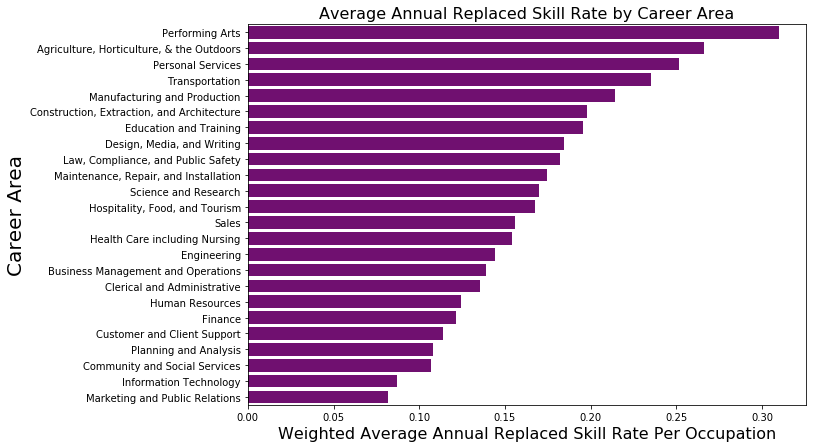

In [124]:
df_ind_sn=get_ind_score_df(caon, orp,'replaced skill rate')
pylab.figure(figsize=(10,7))
b=sns.barplot(x="replaced skill rate", y="industry", data=df_ind_sn, color='purple')
b.axes.set_title("Average Annual Replaced Skill Rate by Career Area",fontsize=16)
b.set_xlabel("Weighted Average Annual Replaced Skill Rate Per Occupation",fontsize=16)
b.set_ylabel("Career Area",fontsize=20)

Text(0, 0.5, 'Career Area')

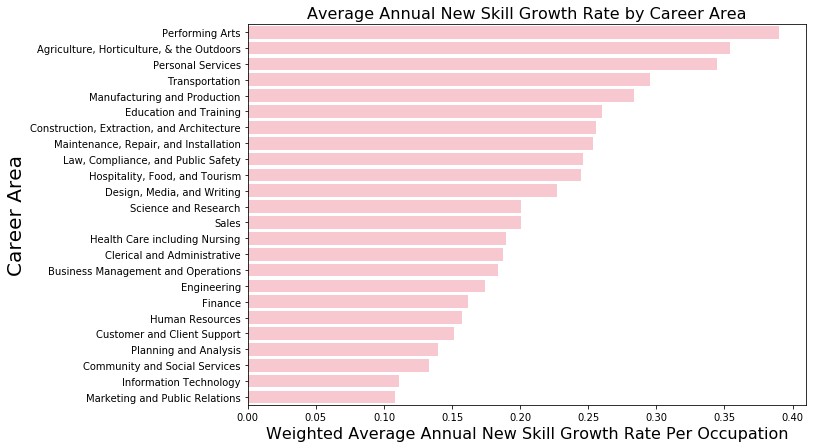

In [125]:
df_ind_sn=get_ind_score_df(caon, ogro,'new skill growth rate')
pylab.figure(figsize=(10,7))
b=sns.barplot(x="new skill growth rate", y="industry", data=df_ind_sn, color='pink')
b.axes.set_title("Average Annual New Skill Growth Rate by Career Area",fontsize=16)
b.set_xlabel("Weighted Average Annual New Skill Growth Rate Per Occupation",fontsize=16)
b.set_ylabel("Career Area",fontsize=20)

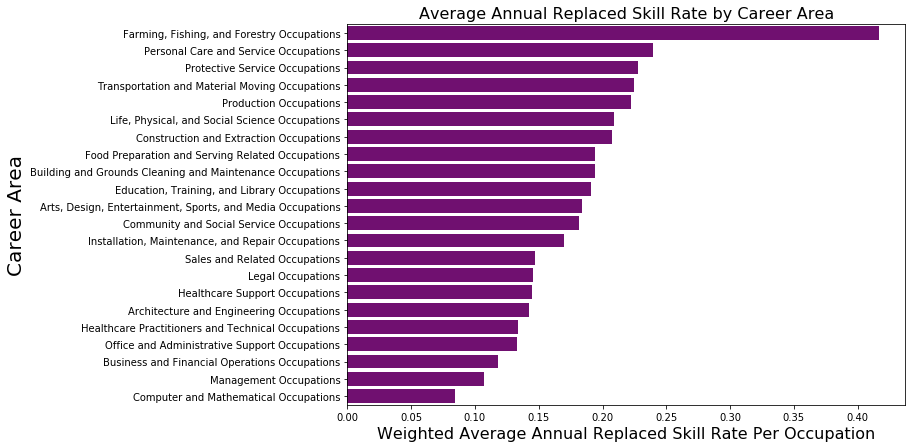

In [33]:
df_ind_sn=get_ind_score_df(gon, orp,'replaced skill rate')
pylab.figure(figsize=(10,7))
b=sns.barplot(x="replaced skill rate", y="industry", data=df_ind_sn, color='purple')
b.axes.set_title("Average Annual Replaced Skill Rate by Career Area",fontsize=16)
b.set_xlabel("Weighted Average Annual Replaced Skill Rate Per Occupation",fontsize=16)
b.set_ylabel("Career Area",fontsize=20)
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillrepl_cararea.png", bbox_inches='tight')

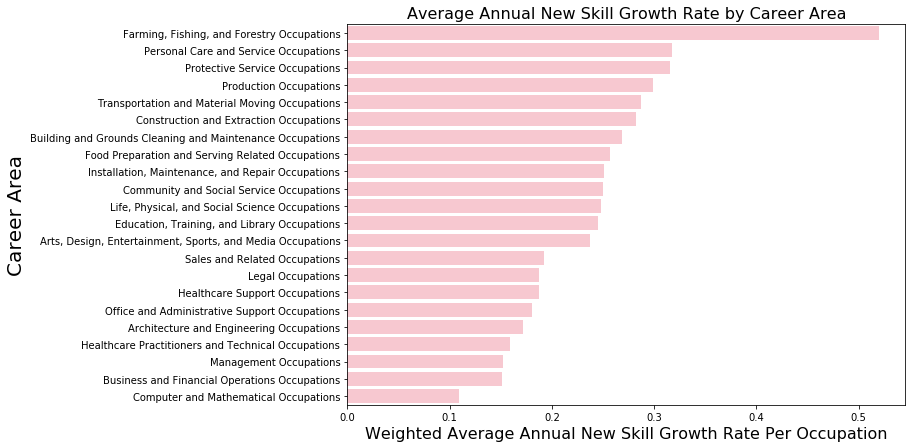

In [34]:
df_ind_sn=get_ind_score_df(gon, ogro,'new skill growth rate')
pylab.figure(figsize=(10,7))
b=sns.barplot(x="new skill growth rate", y="industry", data=df_ind_sn, color='pink')
b.axes.set_title("Average Annual New Skill Growth Rate by Career Area",fontsize=16)
b.set_xlabel("Weighted Average Annual New Skill Growth Rate Per Occupation",fontsize=16)
b.set_ylabel("Career Area",fontsize=20)
plt.savefig("/Users/ditong/Documents/skillProject/description/vis/skillgro_cararea.png", bbox_inches='tight')